In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

df = pd.read_excel('prob_data_with_clusters.xlsx')
data = pd.read_csv('Cleaned_MaxDiff_Model_Data.csv')

In [28]:
#drop churn_risk/tenure
# do not use S3_Recode/churn_risk in modeling
# use churn risk/S3_recode for present
# convert some to numbers for certain models to work
# tree structure being robust/boosting/random forest

# age/gender split/country/favoriate channels/cables&tele?
# drop community/city/original tenure/orginal salutation/all julian dates

# try different metrics -> better than random
# for each kind of labels, how the respondents within the label look like?

# model -> how good can we do than random?
# presentation -> 

In [29]:
data.loc[data['PROVINCE'] == 'Frysl??n','PROVINCE'] = 'Friesland'
grouped = data.groupby(['PROVINCE'])
count_per_name = grouped.size()
print(count_per_name)

PROVINCE
Drenthe           99
Flevoland         24
Friesland         96
Gelderland       301
Groningen         92
Limburg          332
Noord-Brabant    489
Noord-Holland    443
Overijssel       158
Utrecht          171
Zuid-Holland     464
dtype: int64


In [30]:
data.loc[data['S3_Recode'] == 'LOYAL & LIGHT RISK','S3_Recode'] = 'LIGHT RISK'
grouped = data.groupby(['S3_Recode'])
count_per_name = grouped.size()
print(count_per_name)

S3_Recode
HIGH RISK      1317
LIGHT RISK      351
MEDIUM RISK    1001
dtype: int64


In [31]:
data.loc[data['ConvergedStatus'] == 'Converged','ConvergedStatus'] = '1'
data.loc[data['ConvergedStatus'] == 'Not Converged','ConvergedStatus'] = '0'
grouped = data.groupby(['ConvergedStatus'])
count_per_name = grouped.size()
print(count_per_name)

ConvergedStatus
0    1432
1    1237
dtype: int64


In [32]:
data.loc[data['New_Salutation'] == 'Unknown','New_Salutation'] = 'Mr./Ms.'
grouped = data.groupby(['New_Salutation'])
count_per_name = grouped.size()
print(count_per_name)

New_Salutation
Mr.        1993
Mr./Ms.      84
Ms.         592
dtype: int64


In [ ]:
data['Trimmed_Tenure'] = data['Tenure'].astype(str).str[:5]

def Trimmed(value):
    try:
        num = float(value)
        if num > 100:
            return num / 100
        else:
            return num
    except ValueError:
        return value  

data['Trimmed_Tenure'] = data['Trimmed_Tenure'].apply(Trimmed)
data['Trimmed_Tenure'] = data['Trimmed_Tenure'].astype(float)

In [33]:
data=data.drop(['S3_Recode','Churn_risk','CITY_NAME','Tenure','COMMUNITY_NAME','DTV_TIER_OPTION_NAME',
                'CommercialProductName','INTERNET_TIER_OPTION_NAME','InternetSecurityType',
                'MediaBoxType','SALUTATION','TELEPHONY_INSTALLATION_DATE','TVContentPack',
                'PlayLevel','TELEPHONY_TIER_OPTION_NAME',
                'FixedVoicePlan',
                ], axis=1)

In [34]:
data.columns

Index(['Respondent', 'ConvergedStatus', 'Film1', 'FoxSportEDL', 'FoxSportINT',
       'HasCATV', 'HasDTV', 'HasINT', 'HasTEL', 'IntSecurity_Benefit',
       'Kids_Benefit', 'MoviesSeriesL', 'MoviesSeriesStd', 'MoviesSeriesXL',
       'MSL_Benefit', 'PROVINCE', 'Sport', 'Trimmed_Tenure', 'New_Salutation',
       'MDiff_CATV_INSTALLATION_DATE', 'MDiff_DTV_INSTALLATION_DATE',
       'MDiff_INTERNET_INSTALLATION_DATE'],
      dtype='object')

In [35]:
data = data.merge(df, on='Respondent', how='left')

In [36]:
data = data.set_index('Respondent')

In [37]:
#data.to_csv("new maxdiff.csv",index=False)

In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from xgboost import XGBClassifier

In [39]:
#LabelEncoder
label = data.select_dtypes(include=['object', 'category']).columns
label_encoders = {}
for col in label:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [40]:
data.shape

(2669, 52)

In [41]:
#RandomForestClassifier
X = data.drop('HasTEL', axis=1)
y = data['HasTEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

accuracy

0.8177278401997503

In [42]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 72 111]
 [ 35 583]]


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.39      0.50       183
           1       0.84      0.94      0.89       618

    accuracy                           0.82       801
   macro avg       0.76      0.67      0.69       801
weighted avg       0.80      0.82      0.80       801



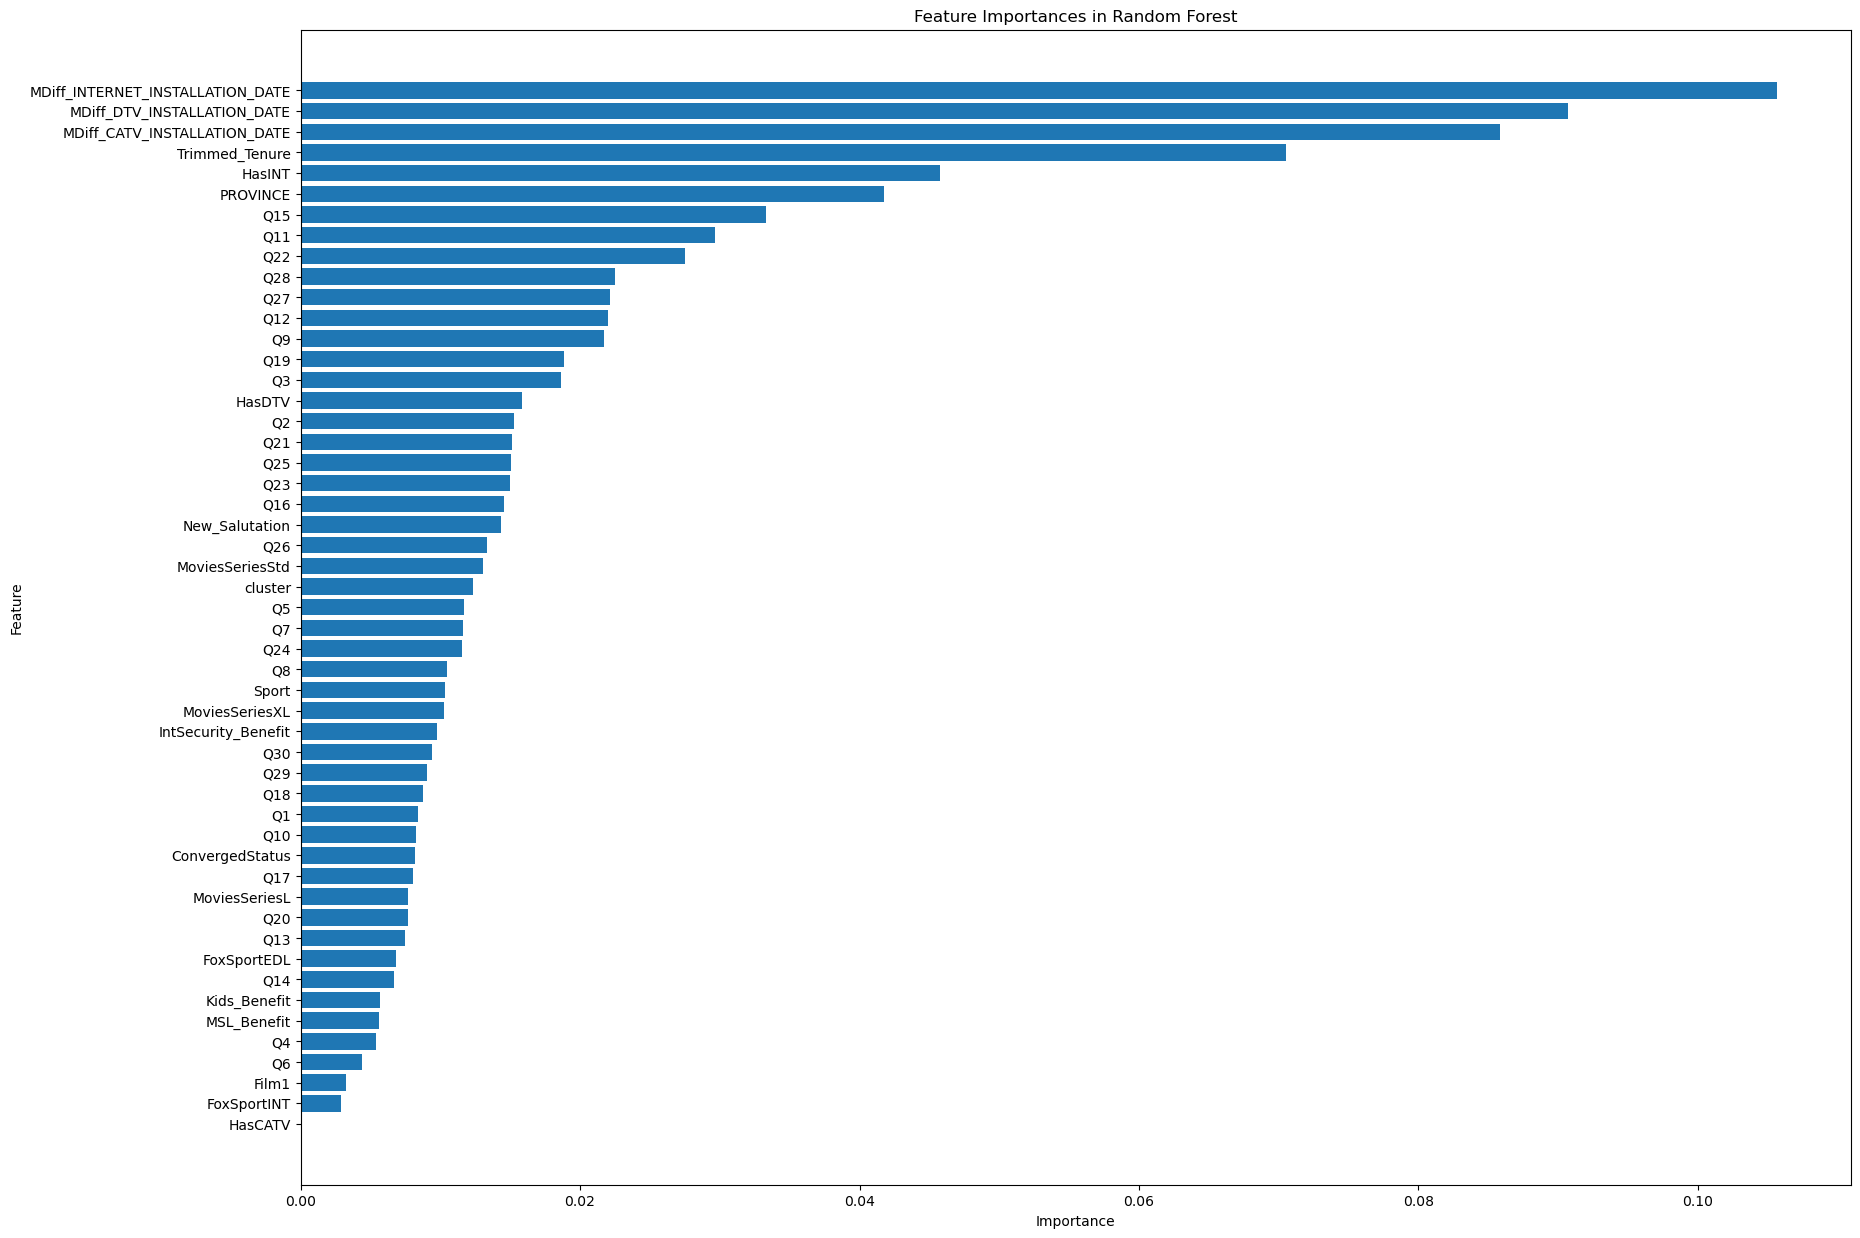

In [44]:
#feature_importances
feature_importances = rf.feature_importances_
features = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features= features.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 15))  
plt.barh(features['Feature'], features['Importance'])  
plt.xlabel('Importance')  
plt.ylabel('Feature')  
plt.title('Feature Importances in Random Forest')  
plt.gca().invert_yaxis()  
plt.show()

In [45]:
# top16 RandomForestClassifier
features=features.head(16) 
top_features = features['Feature'].values
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

rf_top = RandomForestClassifier(n_estimators=100,random_state=42)
rf_top.fit(X_train_top, y_train)

y_pred_top = rf_top.predict(X_test_top)
accuracy_top = accuracy_score(y_test, y_pred_top)


accuracy_top

0.8102372034956304

In [46]:
cm = confusion_matrix(y_test, y_pred_top)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 75 108]
 [ 44 574]]


In [47]:
print(classification_report(y_test, y_pred_top))

              precision    recall  f1-score   support

           0       0.63      0.41      0.50       183
           1       0.84      0.93      0.88       618

    accuracy                           0.81       801
   macro avg       0.74      0.67      0.69       801
weighted avg       0.79      0.81      0.79       801



In [48]:
# XGBOOST
X = data.drop(['HasTEL'], axis=1)
y = data['HasTEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


xgb_model = XGBClassifier(n_estimators=1000,random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

accuracy


0.7865168539325843

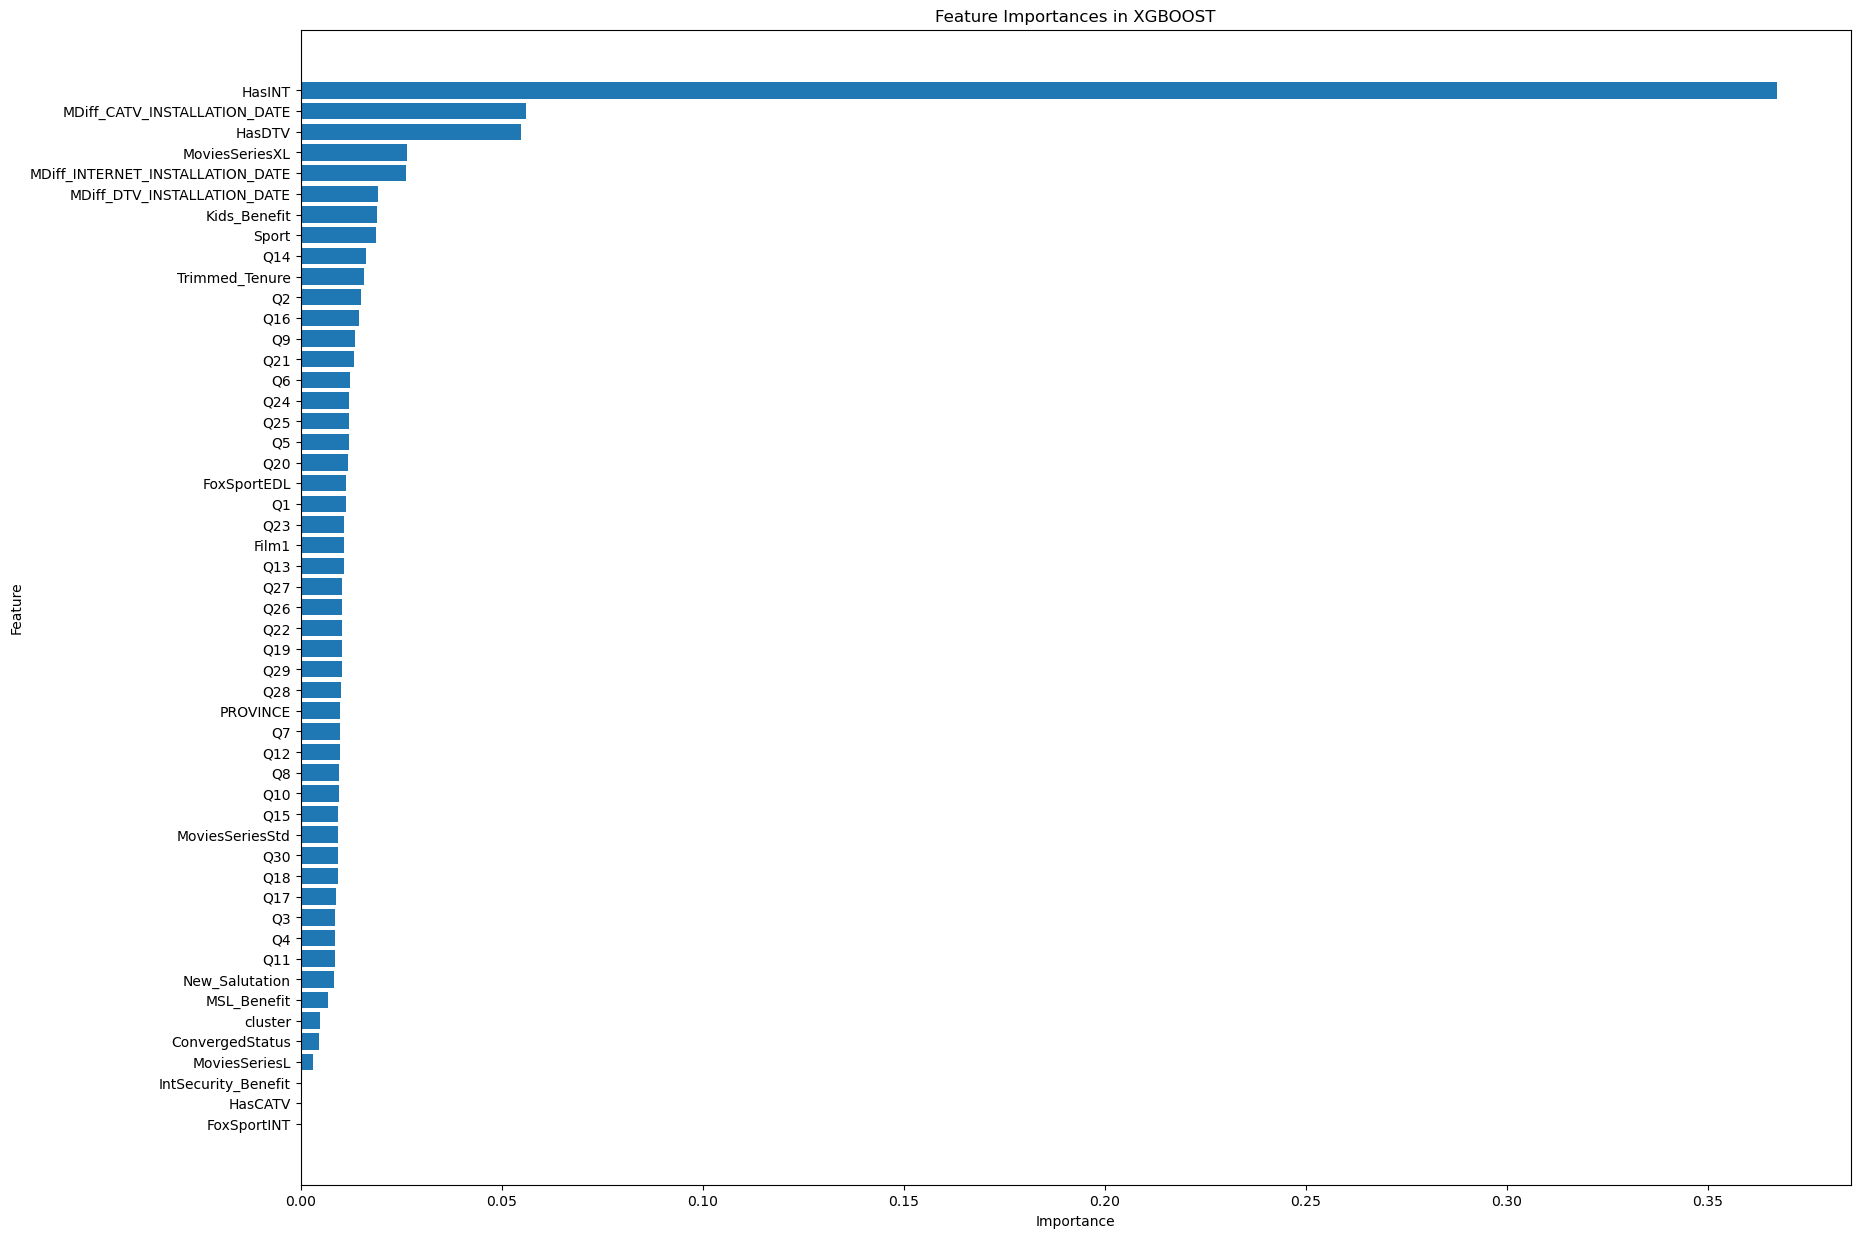

In [49]:
feature_importances = xgb_model.feature_importances_

features = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features= features.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 15))  
plt.barh(features['Feature'], features['Importance'])  
plt.xlabel('Importance')  
plt.ylabel('Feature')  
plt.title('Feature Importances in XGBOOST')  
plt.gca().invert_yaxis()  
plt.show()


In [50]:
# XGBOOST top
features=features.head(7) 
top_features = features['Feature'].values
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

xgb_top = XGBClassifier(n_estimators=100,random_state=42)
xgb_top.fit(X_train_top, y_train)

y_pred_top = xgb_top.predict(X_test_top)
accuracy_top = accuracy_score(y_test, y_pred_top)


accuracy_top

0.8089887640449438

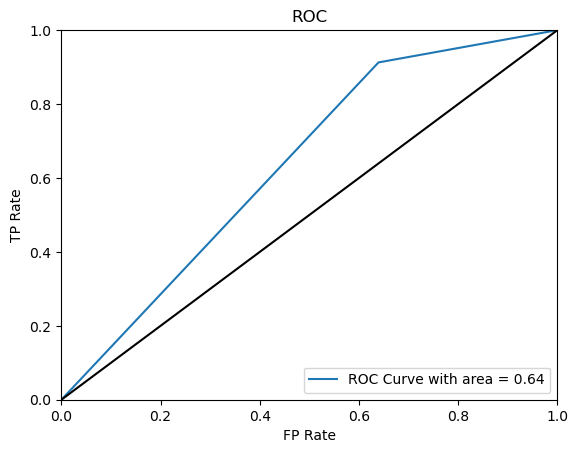

In [51]:
from sklearn.metrics import roc_curve, auc
(fpr, tpr, thresholds) = roc_curve(y_test,y_pred)

area = auc(fpr,tpr)
plt.clf() 
plt.plot(fpr,tpr,label="ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [52]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = LogisticRegression(max_iter=10000, random_state=42)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

accuracy

0.8127340823970037